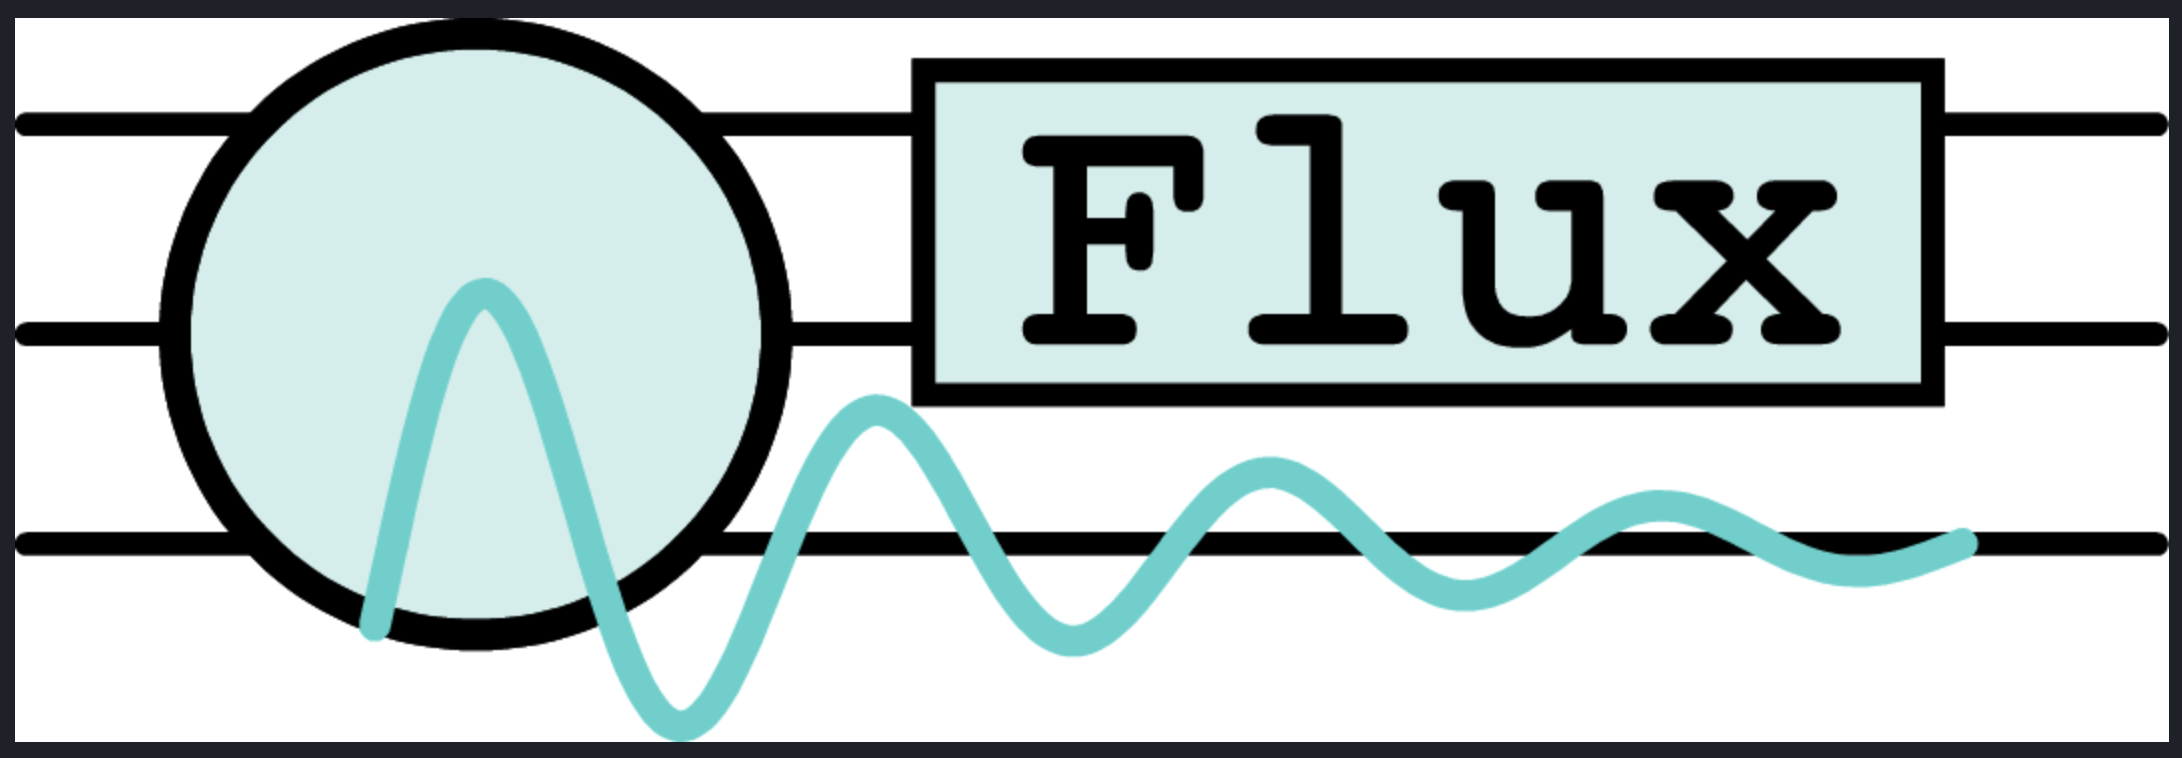

# **QFlux Tutorial**

This notebook seeks to illustrate functionality of the `open_systems` module of `qflux` as explained in Part IV of the tutorial manuscripts.

- **Part IV:** "QFlux: Quantum Circuit Implementations for Molecular Dynamics. Part IV - Dilation method for Open Systems." Xiaohan Dan, Saurabh Shivpuje, Yuchen Wang, Brandon C. Allen, Delmar G. A. Cabral, Pouya Khazaei, Alexander V. Soudackov, Zixuan Hu, Ningyi Lyu, Eitan Geva, Sabre Kais, and Victor S. Batista.

**Note:** Each section builds on the previous ones. **Execute the cells sequentially**, as later sections may rely on functions and data generated earlier.

# Table of Contents

<ul>
  <li>Section 2
    <ul>
      <li><a href="#Script2pt1">Script 2.1: Obtaining Kraus Operators From The Propagator</a></li>
      <li><a href="#Script2pt2">Script 2.2: Dilation</a></li>
    </ul>
  </li>
  <li>Section 3
    <ul>
      <li><a href="#Script3pt1">Script 3.1: Calculating The Propagator Of The Lindblad Equation</a></li>
      <li><a href="#Script3pt2">Script 3.2: Solving The Lindblad Equation Via Matrix Exponential</a></li>
      <li><a href="#Script3pt3">Script 3.3: Qutip For Exact Solutions</a></li>
    </ul>
  </li>
  <li>Section 4
    <ul>
      <li><a href="#Script4pt1">Script 4.1: Set Up The Spin-1/2 System</a></li>
      <li><a href="#Script4pt2">Script 4.2: Propagate The Spin-1/2 System</a></li>
      <li><a href="#Script4pt3">Script 4.3: Plot The Results: Spin 1/2 System</a></li>
      <li><a href="#Script4pt4">Script 4.4: Simulating The Spin-1/2 System With QFlux</a></li>
      <li><a href="#Script4pt5">Script 4.5: Quantum Simulation Of Amplitude Damping With QFlux</a></li>
      <li><a href="#Script4pt6">Script 4.6: Plot The Population Dynamics</a></li>
      <li><a href="#Script4pt7">Script 4.7: Amplitude Damping Channel: Propagator</a></li>
      <li><a href="#Script4pt8">Script 4.8: Amplitude Damping Channel: Quantum Simulation</a></li>
    </ul>
  </li>
  <li>Section 5
    <ul>
      <li><a href="#Script5pt1">Script 5.1: Spin Chain Parameter And Initial State</a></li>
      <li><a href="#Script5pt2">Script 5.2: Spin Chain Hamiltonian</a></li>
      <li><a href="#Script5pt3">Script 5.3: Spin Chain Collapse Operators</a></li>
      <li><a href="#Script5pt4">Script 5.4: Spin Chain Dynamics</a></li>
      <li><a href="#Script5pt5">Script 5.5: Plot The Results: Spin Chain</a></li>
      <li><a href="#Script5pt6">Script 5.6: Simulating Spin Chain Dynamics With QFlux</a></li>
      <li><a href="#Script5pt7">Script 5.7: Quantum Simulation Of Spin Chain With QFlux</a></li>
      <li><a href="#Script5pt8">Script 5.8: Plot The Quantum Result Of Spin Chain</a></li>
      <li><a href="#Script5pt9">Script 5.9: Quantum Simulation Of Spin Chain</a></li>
    </ul>
  </li>
  <li>Section 6
    <ul>
      <li><a href="#Script6pt1">Script 6.1: Double-Well Potential</a></li>
      <li><a href="#Script6pt2">Script 6.2: Eigenstates In The Double-Well Potential</a></li>
      <li><a href="#Script6pt3">Script 6.3: Express Operators In Term Of Eigenstate Basis</a></li>
      <li><a href="#Script6pt4">Script 6.4: Simulate The Dynamics Of The Double-Well</a></li>
      <li><a href="#Script6pt5">Script 6.5: Simulating Double-Well Dynamics With QFlux</a></li>
      <li><a href="#Script6pt6">Script 6.6: Quantum Simulation Of Double-Well With QFlux</a></li>
      <li><a href="#Script6pt7">Script 6.7: The Double-Well Propagator</a></li>
      <li><a href="#Script6pt8">Script 6.8: Obtaining Kraus Operators From The Propagator</a></li>
      <li><a href="#Script6pt9">Script 6.9: Initial State And Observable</a></li>
      <li><a href="#Script6pt10">Script 6.10: Quantum Simulation Of Double-Well</a></li>
    </ul>
  </li>
</ul>

## Installation and Imports

In [ ]:
!pip install qflux

In [ ]:
# Numerical Tools Imports
import numpy as np
import scipy.linalg as LA
from qutip import mesolve, Qobj

# Plotting Imports
import matplotlib.pyplot as plt

# QFlux Imports
import qflux.open_systems.params as pa
from qflux.open_systems.numerical_methods import DynamicsOS
from qflux.open_systems.quantum_simulation import QubitDynamicsOS
from qflux.open_systems.trans_basis import ham_to_pauli

# Qiskit Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator

# Section 2

## Script 2.1: Obtaining Kraus Operators From The Propagator <a name="Script2pt1"></a>

In [ ]:
import numpy as np
import scipy.linalg as LA

def gen_Kraus_list(Gmat,N,tol=1E-5):
    """
    Generate the Kraus operators from the propagator with a given tolerance
    Input:
    - Gmat: matrix of the propagator (numpy array of shape (N^2, N^2)).
    - N: The system Hilbert space dimension
    - tol: tolerance for the Kraus operator representation.
    Returns:
    - Kraus: List of Kraus operators
    """
    # defining the Choi matrix from the matrix of the propagator
    C_mat = np.zeros(Gmat.shape,dtype=np.complex128)
    for i in range(N):
        for j in range(N):
            C_matij = np.zeros(Gmat.shape,dtype=np.complex128)
            for k in range(N):
                for l in range(N):
                    C_matij[i*N+k,l*N+j] = Gmat[j*N+k,l*N+i]
            C_mat += C_matij

    Kraus = []
    val,arr = LA.eigh(C_mat)
    for i in range(len(val)):
        if (val[i]>tol):
            Mi = np.sqrt(val[i])*arr[:,i].reshape(N,N)
            Kraus.append(Mi.conj().T)
    return Kraus


## Script 2.2: Dilation <a name="Script2pt2"></a>

In [ ]:
def dilate(array,Isscale=True):

    if(Isscale):
        # Normalization factor, 1.1 times martix's norm to ensure contraction
        norm = LA.norm(array,2)*1.1
        array_new = array/norm
    else:
        array_new = array

    ident = np.eye(array.shape[0])

    # Calculate the conjugate transpose of the G propagator
    fcon = (array_new.conjugate()).T

    # Calculate the defect matrix for dilation
    fdef = LA.sqrtm(ident - np.dot(fcon, array_new))

    # Calculate the defect matrix for the conjugate of the G propagator
    fcondef = LA.sqrtm(ident - np.dot(array_new, fcon))

    # Dilate the G propagator to create a unitary operator
    array_dilated = np.block([[array_new, fcondef], [fdef, -fcon]])
    if(Isscale):
        return array_dilated, norm
    else:
        return array_dilated


# Section 3

## Script 3.1: Calculating The Propagator Of The Lindblad Equation <a name="Script3pt1"></a>

In [ ]:
def Gt_matrix_expo(H, L, time_arr, Is_show_step = False):
    """
    Getting the propagator of the Lindblad equation by matrix exponential
    Parameters:
    - H: Hamiltonian of the system (numpy array of shape (N, N)).
    - time_arr: Time array for dynamic simulation (array).
    - L: List of Collapse operators, with each operator is a numpy array of shape (N, N).
    Returns:
    - G_prop: List of propagators.
    """
    Nsys = H.shape[0]
    ident_h = np.eye(Nsys, dtype=np.complex128)

    # Amatrix for time-derivation of the vectorized density matrix
    Amat = -1j * (np.kron(H, ident_h) - np.kron(ident_h, H.T))
    for i in range(len(L)):
        Amat += 0.5 * (2.0 * (np.kron(L[i], L[i].conj()))
                           - np.kron(ident_h, L[i].T @ L[i].conj())
                           - np.kron(L[i].T.conj() @ L[i], ident_h))

    G_prop = []
    for i in range(len(time_arr)):
        if(Is_show_step): print('step',i,'time',time_arr[i])
        Gt = LA.expm(Amat * time_arr[i])
        G_prop.append(Gt)
    return G_prop


## Script 3.2: Solving The Lindblad Equation Via Matrix Exponential <a name="Script3pt2"></a>

In [ ]:
def propagate_matrix_exp(H, rho0, time_arr, L, observable, Is_store_state = False, Is_show_step = False, Is_Gt = False):
    """
    Solving the Lindblad equation by matrix exponential
    Parameters:
    - H: Hamiltonian of the system (numpy array of shape (N, N)).
    - rho0: Initial density matrix (numpy array of shape (N, N)).
    - time_arr: Time array for dynamic simulation (array).
    - L: List of Collapse operators, with each operator is a numpy array of shape (N, N).
    - observable: Observable for which the expectation value is computed (numpy array of shape (N, N)).
    - Is_store_state: Boolean variable that determines whether to output the density matrix list
    - show_step: Boolean variable that determines whether to print the current step during simulation
    Returns:
    - result: A class containing all the results
      result.expect: List of expectation values of the observable over time.
      result.G_prop: List of propagators.
      result.density_matrix: List of density matrices.
    """

    class Result:
        def __init__(self):
            self.expect = []
            if(Is_store_state):
                self.density_matrix = []
            if(Is_Gt):  self.Gprop = None
    result = Result()

    # Getting the propagator of the Lindblad equation
    G_prop = Gt_matrix_expo(H, L, time_arr, Is_show_step)
    if(Is_Gt):  result.Gprop = G_prop

    # initialized vectorized density matrix
    Nsys = H.shape[0]
    vec_rho0 = rho0.reshape(Nsys**2)

    for i in range(len(time_arr)):

        vec_rhot = G_prop[i] @ vec_rho0

        # get the density matrix by reshaping
        rhot = vec_rhot.reshape(Nsys, Nsys)

        if(Is_store_state):  result.density_matrix.append(rhot)
        result.expect.append(np.trace(rhot @ observable).real)

    return result


## Script 3.3: Qutip For Exact Solutions <a name="Script3pt3"></a>

In [ ]:
from qutip import mesolve, Qobj

def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops=c_ops, e_ops=observable)
    return result.expect


# Section 4

## Script 4.1: Set Up The Spin-1/2 System <a name="Script4pt1"></a>

In [ ]:
from qflux.open_systems import params as pa

In [ ]:
# The Spin-1/2 system Hamiltonian
H_1spin = 2 * np.pi * 0.1 * pa.X

# The jump operator and damping rate of Spin-1/2 system
gamma_1spin = 0.05
L_1spin = np.sqrt(gamma_1spin)*pa.X

# Initial density matrix
rho0_1spin = np.outer(pa.spin_up, pa.spin_up.conj())

# Time array for simulation
time_arr = np.linspace(0, (250 - 1) * 0.1, 250)

## Script 4.2: Propagate The Spin-1/2 System <a name="Script4pt2"></a>

In [ ]:
# Matrix Exponential Propagation
result_matrix_exp = propagate_matrix_exp(H_1spin, rho0_1spin, time_arr, [L_1spin], pa.Z)

# QuTiP Propagation for Liouville equation (no collapse operator)
expec_vals_qutip_Liouv = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [], Qobj(pa.Z))

# QuTiP Propagation for Lindblad equation
expec_vals_qutip_Lindblad = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [Qobj(L_1spin)], Qobj(pa.Z))

## Script 4.3: Plot The Results: Spin 1/2 System <a name="Script4pt3"></a>

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,2))
plt.plot(time_arr, result_matrix_exp.expect,'b-', label = "Matrix Exponential")
plt.plot(time_arr, expec_vals_qutip_Lindblad[0],'ko',markersize=4,markevery=4, label = "QuTiP_Lindblad")
plt.plot(time_arr, expec_vals_qutip_Liouv[0],'r-', label = "QuTiP_Liouville")
plt.xlabel('time',fontsize=15)
plt.ylabel('<$\sigma^z$>(t)',fontsize=15)
plt.legend(loc = 'upper right')

## Script 4.4: Simulating The Spin-1/2 System With QFlux <a name="Script4pt4"></a>

In [ ]:
import qflux.open_systems.params as pa
from qflux.open_systems.numerical_methods import DynamicsOS
from qflux.open_systems.quantum_simulation import QubitDynamicsOS

# Classical Simulation
# set the Hamiltonian and initial state
# The Spin-1/2 system Hamiltonian
Hsys = 2 * np.pi * 0.1 * pa.X

# The collapse operator and damping rate of Spin-1/2 system
gamma = 0.05
c_ops = np.sqrt(gamma)*pa.X

# Initial density matrix
rho0 = np.outer(pa.spin_up, pa.spin_up.conj())

# Time array for simulation
time_arr = np.linspace(0, (250 - 1) * 0.1, 250)

# instantiation
spin1_puresys = DynamicsOS(Nsys=2, Hsys=Hsys, rho0=rho0)
spin1_dissipative = DynamicsOS(Nsys=2, Hsys=Hsys, rho0=rho0, c_ops = [c_ops])

# propagation
# QuTiP Propagation for the pure system Liouville equation (for comparison)
expec_vals_qutip_Liouv = spin1_puresys.propagate_qt(time_arr=time_arr, observable=pa.Z)

# matrix exponential propagation
result_matrix_exp = spin1_dissipative.propagate_matrix_exp(time_arr=time_arr, observable=pa.Z)

# QuTiP Propagation for the Lindblad equation
expec_vals_qutip_Lindblad = spin1_dissipative.propagate_qt(time_arr=time_arr, observable=pa.Z)

## Script 4.5: Quantum Simulation Of Amplitude Damping With QFlux <a name="Script4pt5"></a>

In [ ]:
# Quantum Simulation: Amplitude damping channel
# System Hamiltonian
Hsys = 0.0 * pa.I

# The collapse operator and damping rate
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
c_ops = np.sqrt(gamma)*pa.sigmap

# Initial density matrix
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex128)

time_sdam = np.arange(0, 1000, 1) #time array, from t=0 to t=1000 ps

# instantiation
spin1_sdam = QubitDynamicsOS(rep='Density', Nsys=2, Hsys=Hsys, rho0=rho0_sdam, c_ops = [c_ops])
# set qubit state to measurement
spin1_sdam.set_count_str(['000','011'])
# set the dilation method, which can be 'Sz-Nagy' or 'SVD' or 'SVD-Walsh'
spin1_sdam.set_dilation_method('SVD')

# quantum simulation
Pop_qc = spin1_sdam.qc_simulation_vecdens(time_sdam)

# compare to classical
res_sdam_classical = spin1_sdam.propagate_matrix_exp(time_sdam, observable=pa.Z, Is_store_state = True)

Pop_Mexp = np.zeros_like(Pop_qc['data'])
for i in range(len(time_sdam)):
    Pop_Mexp[i,0] = res_sdam_classical.density_matrix[i][0,0].real
    Pop_Mexp[i,1] = res_sdam_classical.density_matrix[i][1,1].real

## Script 4.6: Plot The Population Dynamics <a name="Script4pt6"></a>

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(time_sdam,Pop_qc['data'][:,0],'r-',label="quantum,|0>")
plt.plot(time_sdam,Pop_Mexp[:,0],'ko',markersize=5,markevery=40,label="benchmark,|0>")
plt.plot(time_sdam,Pop_qc['data'][:,1],'b-',label="quantum,|1>")
plt.plot(time_sdam,Pop_Mexp[:,1],'yo',markersize=5,markevery=40,label="benchmark,|1>")
plt.xlabel('time (ps)',fontsize=15)
plt.ylabel('$P(t)$',fontsize=15)
plt.legend(loc = 'upper right')

## Script 4.7: Amplitude Damping Channel: Propagator <a name="Script4pt7"></a>

In [ ]:
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
time_sdam = np.arange(0, 1000, 1) # time array, from t=0 to t=1000 ps
Nsys_1spin = 2

# defining the initial density matrix rho
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex128)
vec0_sdam = rho0_sdam.reshape(Nsys_1spin**2)
norm0_sdam = LA.norm(vec0_sdam,2)
vec0_sdam /= norm0_sdam

Pop_Mexp = np.zeros((len(time_sdam),2),dtype=np.float128) #population array

Gprop_sdam = Gt_matrix_expo(0.0*pa.X, [np.sqrt(gamma)*pa.sigmap], time_sdam)

for i in range(len(time_sdam)):

  Gt = Gprop_sdam[i]
  rhot_sdam = (Gt@vec0_sdam).reshape(Nsys_1spin,Nsys_1spin)*norm0_sdam
  Pop_Mexp[i,0] = rhot_sdam[0,0].real
  Pop_Mexp[i,1] = rhot_sdam[1,1].real

## Script 4.8: Amplitude Damping Channel: Quantum Simulation <a name="Script4pt8"></a>

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
# initial state in the dilated space
rho0_sdam_dil = np.concatenate((vec0_sdam,np.zeros(Nsys_1spin**2)))

aersim = AerSimulator()
shots = 2000
Pop_qc = np.zeros((len(time_sdam),2),dtype=np.float128)

for i in range(len(time_sdam)):
    if(i%100==0):print('istep',i)
    qr = QuantumRegister(2+1)  # Create a quantum register
    cr = ClassicalRegister(2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sdam_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sdam[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)
    # Apply the unitary operator to the quantum circuit's qubits and measure
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)

    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    if '011' and '000' in counts1:
      Pop_qc[i,0] = np.sqrt(counts1['000']/shots)*norm*norm0_sdam
      Pop_qc[i,1] = np.sqrt(counts1['011']/shots)*norm*norm0_sdam
    else:
      print(i,'shots=',shots,"no counts for up state")

# Section 5

## Script 5.1: Spin Chain Parameter And Initial State <a name="Script5pt1"></a>

In [ ]:
# the system Hamiltonian parameter
nsite = 3 #this states how many spins in the simulation
Nsys_sc = 2**nsite #this is the dimension of the Hilbert space
Omegai_list = [0.65, 1.0, 1.0]
Jix_list = [0.75, 1.0]
Jiy_list = [0.75, 1.0]
Jiz_list = [0.0, 0.0]

# set up the initial state at [up,down,down...]
init_state = pa.spin_up
for i in range(nsite-1):
  init_state = np.kron(init_state,pa.spin_down)

# set up the initial density matrix according to initial state
rho0_sc = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex128)
rho0_sc += np.outer(init_state,init_state.conj())

# time array for simulation
nsteps = 250
time_arr = np.linspace(0, (nsteps - 1) * 0.1, nsteps)

## Script 5.2: Spin Chain Hamiltonian <a name="Script5pt2"></a>

In [ ]:
# the diagnoal part of the Hamiltonian
H_diag = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex128)
for n in range(nsite):
    tmp = 1.0
    for i in range(nsite):
        if(i==n):
            tmp = np.kron(tmp,pa.Z)
        else:
            tmp = np.kron(tmp,pa.I)
    H_diag += Omegai_list[n]*tmp

# the non-diagnoal (coupling) part of the Hamiltonian
H_coup = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex128)
XX = np.kron(pa.X,pa.X)
YY = np.kron(pa.Y,pa.Y)
ZZ = np.kron(pa.Z,pa.Z)
for n in range(nsite-1):
    coup_tmp = Jix_list[n]*XX+Jiy_list[n]*YY+Jiz_list[n]*ZZ
    tmp = 1.0
    for i in range(nsite-1):
        if(n==i):
            tmp = np.kron(tmp,coup_tmp)
        else:
            tmp = np.kron(tmp,pa.I)
    H_coup += tmp
Hsys_sc = H_diag - 0.5 * H_coup
Hsys_sc_qobj = Qobj(Hsys_sc)

## Script 5.3: Spin Chain Collapse Operators <a name="Script5pt3"></a>

In [ ]:
# The lindblad damping rate
Gamma1 = [0.016]*nsite
Gamma2 = [0.0523]*nsite

# The Collapse operators
L_sc = []
L_sc_qobj = [] #this stores Qobj type for QuTiP methods

sigma2 = pa.sigmap@pa.sigmam

for isite in range(nsite):
    # Lindbladian for type 1
    res = 1.0
    for j in range(nsite):
        if(j==isite):
            res = np.kron(res,pa.sigmam)*np.sqrt(Gamma1[isite])
        else:
            res = np.kron(res,pa.I)
    L_sc.append(res)
    L_sc_qobj.append(Qobj(res))

    # Lindbladian for type 2
    res = 1.0
    for j in range(nsite):
        if(j==isite):
            res = np.kron(res,sigma2)*np.sqrt(Gamma2[isite])
        else:
            res = np.kron(res,pa.I)
    L_sc.append(res)
    L_sc_qobj.append(Qobj(res))

## Script 5.4: Spin Chain Dynamics <a name="Script5pt4"></a>

In [ ]:
# Matrix Exponential Propagation
result_matrix_exp = propagate_matrix_exp(Hsys_sc, rho0_sc, time_arr, L_sc, rho0_sc)

rho0_sc_qobj = Qobj(rho0_sc)
# QuTiP Propagation for Liouville equation (no collapse operator)
result_qutip_Liouv = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, [], rho0_sc_qobj)

# QuTiP Propagation for Lindblad equation
result_qutip_Lindblad = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, L_sc_qobj, rho0_sc_qobj)

As_matrix_exp = np.sqrt(result_matrix_exp.expect[:])
As_qutip = np.sqrt(result_qutip_Lindblad[0][:])
As_qutip_liouv = np.sqrt(result_qutip_Liouv[0][:])

## Script 5.5: Plot The Results: Spin Chain <a name="Script5pt5"></a>

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_matrix_exp,'b-', label="Matrix Exponential")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP_Lindblad")
plt.plot(time_arr,As_qutip_liouv,'r-',label="Pure System")
plt.xlabel('time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

## Script 5.6: Simulating Spin Chain Dynamics With QFlux <a name="Script5pt6"></a>

In [ ]:
# Classical Simulation
# instantiation
spin_chain_puresys =  DynamicsOS(Nsys=Nsys_sc, Hsys=Hsys_sc, rho0=rho0_sc)
spin_chain_opensys =  DynamicsOS(Nsys=Nsys_sc, Hsys=Hsys_sc, rho0=rho0_sc, c_ops = L_sc)

# propagation
# QuTiP Propagation for the pure system Liouville equation (for comparison)
result_qutip_Liouv = spin_chain_puresys.propagate_qt(time_arr=time_arr, observable=rho0_sc)

# matrix exponential propagation
result_matrix_exp = spin_chain_opensys.propagate_matrix_exp(time_arr=time_arr, observable=rho0_sc)

# QuTiP Propagation for the Lindblad equation
result_qutip_Lindblad = spin_chain_opensys.propagate_qt(time_arr=time_arr, observable=rho0_sc)

As_matrix_exp = np.sqrt(result_matrix_exp.expect[:])
As_qutip = np.sqrt(result_qutip_Lindblad[0][:])
As_qutip_liouv = np.sqrt(result_qutip_Liouv[0][:])

## Script 5.7: Quantum Simulation Of Spin Chain With QFlux <a name="Script5pt7"></a>

In [ ]:
# Quantum Simulation
qspin_chain = QubitDynamicsOS(rep='Density',Nsys=Nsys_sc, Hsys=Hsys_sc, rho0=rho0_sc, c_ops = L_sc)
qspin_chain.set_count_str(['0011011'])

res_qc_1k = qspin_chain.qc_simulation_vecdens(time_arr,shots=1000)
res_qc_1w = qspin_chain.qc_simulation_vecdens(time_arr,shots=10000)

As_qc_1k = np.sqrt(res_qc_1k['data'])
As_qc_1w = np.sqrt(res_qc_1w['data'])

## Script 5.8: Plot The Quantum Result Of Spin Chain <a name="Script5pt8"></a>

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_qc_1k[:],'r-',label=f"quantum,counts={1000}")
plt.plot(time_arr,As_qc_1w[:],'b-',label=f"quantum,counts={10000}")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP benchmark")
plt.xlabel('Time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

## Script 5.9: Quantum Simulation Of Spin Chain <a name="Script5pt9"></a>

In [ ]:
# initial state of the spin chain in the dilated space
# rho0_sc=|up,down,...><up,down,...|, has defined in the Digital computer simulation part
rho0_sc_dil = np.concatenate((rho0_sc.reshape(Nsys_sc**2),np.zeros(Nsys_sc**2)))

# The propagator of the spin chain Lindblad equation
Gprop_sc = Gt_matrix_expo(Hsys_sc, L_sc, time_arr)

aersim=AerSimulator()
shots_arr = [1000,10000]
As_qc_1k = np.zeros((nsteps),dtype=np.float128)
As_qc_1w = np.zeros((nsteps),dtype=np.float128)
As_qc = [As_qc_1k,As_qc_1w]
nsteps = len(time_arr)

for i in range(nsteps):
    if(i%10==0):print('istep',i)
    qr = QuantumRegister(nsite*2+1)  # Create a quantum register
    cr = ClassicalRegister(nsite*2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sc_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sc[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)

    # Apply the unitary operator to the quantum circuit's qubits
    qc.unitary(U_G_op, qr)

    qc.measure(qr, cr)

    for ishot in range(len(shots_arr)):
        counts1 = aersim.run(qc,shots=shots_arr[ishot]).result().get_counts()
        if '0011011' in counts1:
          survi_amp = np.sqrt(counts1['0011011']/shots_arr[ishot])*norm
          As_qc[ishot][i] = np.sqrt(survi_amp)
        else:
          print(i,'shots=',shots_arr[ishot],"no counts")

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_qc_1k[:],'r-',label=f"quantum,counts={1000}")
plt.plot(time_arr,As_qc_1w[:],'b-',label=f"quantum,counts={10000}")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP benchmark")
plt.xlabel('Time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

# Section 6

## Script 6.1: Double-Well Potential <a name="Script6pt1"></a>

In [ ]:
def pot_doublewell(x, f=0.0367493, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    xi = x/1.9592
    return f*(a0 + a1*xi + a2*xi**2 + a3*xi**3 + a4*xi**4)

# The parameters
# Note that some unit conversion constants are defined in the pa object (an implementation of the Params class)
mass0 = 1836.15
beta = pa.au2joule/(pa.bolz*300) #1/(kT) in a.u. units
omega = 0.00436 #the frequency associate with the right well
kappa = 1/(10/pa.au2fs)
nth = 1/(np.exp(beta*omega)-1)

# set up the grid point
xmin = -4.0
xmax = 4.0
ndvr = 1024
xgrid = np.linspace(xmin,xmax,ndvr)

pot_arr = pot_doublewell(xgrid)

plt.plot(xgrid,pot_arr,'k', label = "V(x)")
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('V(x) (a.u.)',fontsize=15)
plt.legend(loc = 'upper right')

## Script 6.2: Eigenstates In The Double-Well Potential <a name="Script6pt2"></a>

In [ ]:
import scipy.linalg as LA

def get_eig_state(hamk,pot,xgrid,Nstate):
    """
    get the eigen state for potential in x-space
    input:kinetic energy hamiltonian, potential in x-space
    """
    Mata = hamk.copy()
    for i in range(ndvr):
        Mata[i,i]+=pot[i]

    val,arr = LA.eigh(Mata)
    dx = xgrid[1]-xgrid[0]
    return val[:Nstate],arr[:,:Nstate]/dx**0.5

import scipy.fft as sfft
kgrid = np.zeros(ndvr,dtype=np.float64)
# ak2: kinetic energy array in k-space
ak2   = np.zeros(ndvr,dtype=np.float64)

dx = xgrid[1]-xgrid[0]
dk = 2.0*np.pi/((ndvr)*dx)
coef_k = pa.hbar**2/(2.0*mass0)

for i in range(ndvr):
  if(i<ndvr//2):
    kgrid[i] = i*dk
  else:
    kgrid[i] = -(ndvr-i) * dk

  ak2[i] = coef_k*kgrid[i]**2

akx0 = sfft.ifft(ak2)
# hamk: kinetic hamiltonian Matrix in position x grid space
hamk = np.zeros((ndvr,ndvr),dtype=np.complex128)

for i in range(ndvr):
  for j in range(ndvr):
    if(i<j):
      hamk[i,j] = akx0[i-j].conj()
    else:
      hamk[i,j] = akx0[i-j]

Neig = 50
eneg_DW,psi_DW = get_eig_state(hamk,pot_arr,xgrid,Neig)

## Script 6.3: Express Operators In Term Of Eigenstate Basis <a name="Script6pt3"></a>

In [ ]:
# the eigenstate in the k-space representation
#( by Fourier transform of the original eigenstate in x-space)
psik_DW = np.zeros((ndvr,Neig),dtype=np.complex128)
pre_fac = dx/(2*np.pi)**0.5
for i in range(Neig):
  psik_DW[:,i] = sfft.fft(psi_DW[:,i])*pre_fac

# initial density matrix
ini_occu = np.zeros(Neig,dtype=np.complex128)
ini_occu[5] = 1.0
rho0 = np.outer(ini_occu,ini_occu.conj())

# The operator in the eigenstate
xmat_eig = np.zeros((Neig,Neig),dtype=np.complex128)
pmat_eig = np.zeros((Neig,Neig),dtype=np.complex128)
for i in range(Neig):
  for j in range(Neig):
    xmat_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),xgrid),psi_DW[:,j])*dx
    pmat_eig[i,j] = np.dot(np.multiply(psik_DW[:,i].conj(),kgrid),psik_DW[:,j])*dk

# hamiltonian
H_dw = np.diag(eneg_DW)
# creation/annihilation operator
amat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)+1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)
adegmat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)-1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)

# define the population on the left/right well
x_barrier = 0.37321768
P_R = np.heaviside(xgrid-x_barrier,1)
P_L = 1 - np.heaviside(xgrid-x_barrier,1)

P_R_eig = np.zeros((Neig,Neig),dtype=np.complex128)
P_L_eig = np.zeros((Neig,Neig),dtype=np.complex128)
for i in range(Neig):
  for j in range(Neig):
    P_R_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),P_R),psi_DW[:,j])*dx
    P_L_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),P_L),psi_DW[:,j])*dx

## Script 6.4: Simulate The Dynamics Of The Double-Well <a name="Script6pt4"></a>

In [ ]:
# propogate using QuTiP
gamma1 = np.sqrt(kappa*(nth+1))
gamma2 = np.sqrt(kappa*(nth))
time_qtp = np.linspace(0,1000/pa.au2fs,20000)

# run the dynamics with different eigenstates truncation
result_qtp = {}
for N_eig_use in [20,30,40]:
  c_ops = [gamma1*Qobj(amat_eig[:N_eig_use,:N_eig_use]), gamma2*Qobj(adegmat_eig[:N_eig_use,:N_eig_use])]
  obs = [Qobj(P_R_eig[:N_eig_use,:N_eig_use]), Qobj(P_L_eig[:N_eig_use,:N_eig_use])]
  result_qtp[N_eig_use] = mesolve(Qobj(H_dw[:N_eig_use,:N_eig_use]), Qobj(rho0[:N_eig_use,:N_eig_use]), time_qtp, c_ops, obs, progress_bar=True).expect

# propagation using matrix exponential propagation
N_eig_use=30
c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
observable = P_R_eig[:N_eig_use,:N_eig_use]

time_short = np.linspace(0,1000/pa.au2fs,30) #compare to QuTiP time scale
result_s = propagate_matrix_exp(H_dw[:N_eig_use,:N_eig_use], rho0[:N_eig_use,:N_eig_use], time_short, c_ops, observable, Is_show_step=True)

time_long = np.linspace(0,20000/pa.au2fs,60) #long time propagation
result_dw_l = propagate_matrix_exp(H_dw[:N_eig_use,:N_eig_use], rho0[:N_eig_use,:N_eig_use], time_long, c_ops, observable, Is_store_state = True, Is_show_step=True, Is_Gt=True)

## Script 6.5: Simulating Double-Well Dynamics With QFlux <a name="Script6pt5"></a>

In [ ]:
# ==================classical simulation============================
# propagate using QuTiP
gamma1 = np.sqrt(kappa*(nth+1))
gamma2 = np.sqrt(kappa*(nth))

time_qtp = np.linspace(0,1000/pa.au2fs,20000)

# Double_Well with different eigenstates truncation
dw_eig = {}
result_qtp = {}
for N_eig_use in [20,30,40]:
    c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
    dw_eig[N_eig_use] = DynamicsOS(Nsys = N_eig_use, Hsys = H_dw[:N_eig_use,:N_eig_use], \
                                      rho0 = rho0[:N_eig_use,:N_eig_use], c_ops = c_ops)

    obs = [P_R_eig[:N_eig_use,:N_eig_use], P_L_eig[:N_eig_use,:N_eig_use]]
    result_qtp[N_eig_use] = dw_eig[N_eig_use].propagate_qt(time_qtp, obs, progress_bar=True)

# propagate using matrix exponential propagation
N_eig_use=30
c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
observable = P_R_eig[:N_eig_use,:N_eig_use]

time_short = np.linspace(0,1000/pa.au2fs,30) #compare to QuTiP time scale
result_s = dw_eig[N_eig_use].propagate_matrix_exp(time_short, observable, Is_show_step=True)

time_long = np.linspace(0,20000/pa.au2fs,60) #long time propagation
result_dw_l = dw_eig[N_eig_use].propagate_matrix_exp(time_long, observable, \
                                Is_store_state = True, Is_show_step=True, Is_Gt=True)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(time_qtp*pa.au2fs, result_qtp[20][0], color='tab:red', label='QuTiP (Neig=20)')
plt.plot(time_qtp*pa.au2fs, result_qtp[30][0], '--', color='tab:blue', label='QuTiP (Neig=30)')
plt.plot(time_qtp*pa.au2fs, result_qtp[40][0], 'o', color='k', label='QuTiP (Neig=40)', markevery=500, ms=4)
_ = plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Population')

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(time_qtp*pa.au2fs, result_qtp[30][0], color='tab:blue', label='QuTiP (Neig=30)')
plt.plot(time_short*pa.au2fs, result_s.expect, 'o', color='k', label='Matrix Exponential', ms=4)
_ = plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Population')

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(time_long*pa.au2fs, result_dw_l.expect, '*', color='k', label='Matrix Exponential', ms=4)
_ = plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Population')

## Script 6.6: Quantum Simulation Of Double-Well With QFlux <a name="Script6pt6"></a>

In [ ]:
from qflux.open_systems.quantum_simulation import expand

# ===============Quantum Simulation ====================================
dim_dw = 32

# initial state of the double-well in the dilated space
ini_occu = np.zeros(dim_dw,dtype=np.complex128)
ini_occu[5] = 1.0
rho0 = np.outer(ini_occu,ini_occu.conj())

# hamiltonian
Hsys = H_dw[:dim_dw,:dim_dw]

# collapse operator and observable
c_ops = [gamma1*amat_eig[:dim_dw,:dim_dw], gamma2*adegmat_eig[:dim_dw,:dim_dw]]
observable = P_R_eig[:dim_dw,:dim_dw]

# extract the propagator from result of classical simulation,
# and expand to match the dimension of qubit space
# For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(time_long)/ilarge)
time_qdw = np.zeros(nsteps)
Gprop_dw = []

for i0 in range(nsteps):
    i = i0*ilarge
    org_dim = result_dw_l.density_matrix[i].shape[0]
    Gprop_dw.append(expand(result_dw_l.Gprop[i],org_dim,dim_dw))

    time_qdw[i0] = time_long[i]

# double well instance
dw_quantum = QubitDynamicsOS(rep='Kraus', Nsys=dim_dw, Hsys=Hsys, rho0=rho0, c_ops = c_ops)
dw_quantum.set_observable(observable)

# running the quantum simulation
P_dw_qc = dw_quantum.qc_simulation_kraus(time_qdw, shots=2000,  Gprop = Gprop_dw, tolk = 1E-2, tolo = 5E-3)

## Script 6.7: The Double-Well Propagator <a name="Script6pt7"></a>

In [ ]:
def expand(Gmat_org,Norg,Nexpand):
    Gnew = np.zeros((Nexpand**2,Nexpand**2),dtype=np.complex128)
    for i in range(Norg):
        for j in range(Norg):
            for k in range(Norg):
                for l in range(Norg):
                    Gnew[i*Nexpand+j,k*Nexpand+l] = Gmat_org[i*Norg+j,k*Norg+l]
    return Gnew

dim_dw = 32
Nqb_dw = int(np.log2(dim_dw))

# extract the propagator from result of classical simulation
Gprop_dw = []
for i in range(len(result_dw_l.Gprop)):
    org_dim = result_dw_l.density_matrix[i].shape[0]
    Gprop_dw.append(expand(result_dw_l.Gprop[i],org_dim,dim_dw))

## Script 6.8: Obtaining Kraus Operators From The Propagator <a name="Script6pt8"></a>

In [ ]:
# For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(Gprop_dw)/ilarge)

Kraus_all = {}
for i0 in range(nsteps):
    i = i0*ilarge
    print('istep',i0)

    # get the kraus operators from the propagator
    Kraus_all[i0] = gen_Kraus_list(Gprop_dw[i],dim_dw,tol=1E-2)

## Script 6.9: Initial State And Observable <a name="Script6pt9"></a>

In [ ]:
from qflux.open_systems.trans_basis import ham_to_pauli
from qiskit.quantum_info import SparsePauliOp

# initial state of the double-well in the dilated space
ini_occu = np.zeros(dim_dw,dtype=np.complex128)
ini_occu[5] = 1.0
stat0_dil = np.concatenate((ini_occu,np.zeros(dim_dw)))


# decompose the dilated space observable into summation of tensor product of pauli matrices
Obs_mat = np.zeros((2*dim_dw,2*dim_dw),dtype=np.complex128)
Obs_mat[:dim_dw,:dim_dw] = P_R_eig[:dim_dw,:dim_dw]
Obs_paulis_dic = ham_to_pauli(Obs_mat, Nqb_dw+1, tol=5E-3)

# Prepare the qiskit observable from the pauli strings of observable matrix
data = []
coef = []
for key in Obs_paulis_dic:
    data.append(key)
    coef.append(Obs_paulis_dic[key])
obs_q = SparsePauliOp(data,coef)

## Script 6.10: Quantum Simulation Of Double-Well <a name="Script6pt10"></a>

In [ ]:
from qiskit_aer.primitives import Estimator

# Aer implementation of an Estimator
estimator = Estimator()

shots = 2000

# For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(Gprop_dw)/ilarge)

time_dw_qc = np.zeros((nsteps),dtype=np.float128)
P_dw_qc = np.zeros((nsteps),dtype=np.float128)
for i0 in range(nsteps):

    i = i0*ilarge
    print('istep',i0,i)

    time_dw_qc[i0] = time_long[i]

    matKraus_list = Kraus_all[i0]
    print('len',len(matKraus_list))

    for ikraus in range(len(matKraus_list)):

      # Create the quantum circuit
      qr = QuantumRegister(Nqb_dw+1)
      cr = ClassicalRegister(Nqb_dw+1)
      qc = QuantumCircuit(qr, cr)

      # Initialize the quantum circuit with the initial state
      qc.initialize(stat0_dil, qr)

      # Create a custom unitary operator with the dilated Kraus propagator
      UM = dilate(matKraus_list[ikraus],Isscale=False)
      UM_op = Operator(UM)

      # Apply the unitary operator to the quantum circuit's qubits
      qc.unitary(UM_op, qr)

      result = estimator.run(qc, obs_q, shots = shots).result()
      P_dw_qc[i0] += result.values[0]

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(time_long*pa.au2fs, result_dw_l.expect, color='k', label='Matrix Exponential', ms=4)
plt.plot(time_dw_qc*pa.au2fs, P_dw_qc, 'o', color='tab:red', label="Quantum Simulation")
_ = plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Population')

# Print All Imported Module Versions

In [ ]:
!pip install watermark

In [ ]:
%load_ext watermark

In [44]:
%watermark --iversions

matplotlib: 3.10.0
numpy     : 2.0.2
qflux     : 0.0.7
qiskit    : 2.3.0
qiskit_aer: 0.17.2
qutip     : 5.2.2
scipy     : 1.16.3

